In [1]:
# Load Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Problem and Data Description

There has been a significant increase of "fake news" being posted on sites like Twitter and Facebook in recent years. All of these false statements out there can lead to people believing in these claims that are just not true. This can have many negative effects on people's lives and their views and decisions. It is very important to be able to determine what news is real and what is fake, which is not easy to do. We will create a few deep learning models to attempt to classify real vs fake news with the most accuracy.

The dataset we'll be using has been created from Politifact.com by Kajal Yadav. The dataset contains about 10,000 data points and 6 features ('News_Headline', 'Link_Of_News', 'Source', 'Stated_On', 'Date', 'Label'). Each data point contains the text of a headline as long as information about the headline. The 'Label' feature was manually entered to label the headline as 'True', 'Mostly-True', 'Half-True', 'Barely-True', 'False', 'Pants on Fire'.

Our models will be binary classification models, therefore we will need to alter the 'Label' feature. We'll create a new feature called 'Bin_Label' that will transform the 'Label'. 'True', 'Mostly-True', 'Half-True', 'Barely-True' will be transformed to '0' as real and 'False', 'Pants on Fire' will be transofrmed to '1' as fake. We'll split our data into training and testing. The metrics Loss, Accuracy, and area under the ROC Curve (AUC) will be used to evaluate and compare our models.

# Exploratory Data Analysis

First let's load the data.

In [2]:
# Load Data

data = pd.read_csv("../input/fakereal-news/New Task.csv", encoding = 'latin-1')

Let's take a quick look at the data.

In [3]:
data.head()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE
3,Even so-called moderate Democrats like Joe Bi...,https://www.politifact.com/factchecks/2020/jun...,Paul Junge,"June 10, 2020","June 19, 2020",barely-true
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   News_Headline  9960 non-null   object
 1   Link_Of_News   9960 non-null   object
 2   Source         9960 non-null   object
 3   Stated_On      9960 non-null   object
 4   Date           9960 non-null   object
 5   Label          9960 non-null   object
dtypes: object(6)
memory usage: 467.0+ KB


In [5]:
data.describe()

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label
count,9960,9960,9960,9960,9960,9960
unique,9947,9960,2709,1028,2009,9
top,On changing the rules for filibusters on presi...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"October 9, 20","February 20, 2020",FALSE
freq,3,1,802,51,19,2273


The first output above shows the first 5 rows of the dataset, so we can see what the dataset looks like. The second output shows us that there are 9,960 data points, and all the features are object types. There also appears to be no missing values. The description of the data shows that there are 9,947 unique headlines, which tells us that there may be duplicates in the data. Since the 'News_Headline' feature will be the main feature we'll use to build our models, we will have to remove these duplicates.

The description also tells us there are 9 unique labels, which in the data description it was stated that there were only 6 labels. Let's take a deeper look at the Label feature.

In [6]:
# Label Counts

counts = data['Label'].value_counts()
print(counts)

FALSE          2273
barely-true    1737
mostly-true    1722
half-true      1685
pants-fire     1402
TRUE           1036
full-flop        70
half-flip        27
no-flip           8
Name: Label, dtype: int64


The unknown labels are 'full-flop', 'half-flip', and 'no-flip'. Since we're not sure what these labels mean and as there's not many of them we'll remove these data points before building our models.

Let's take a look at the distribution of real vs fake news.

  Label  Count
0  Real   6180
1  Fake   3675


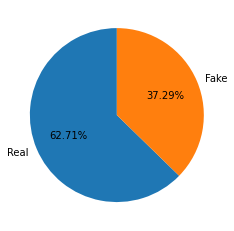

In [7]:
#Label Distribution

real_labels = ['TRUE','mostly-true','half-true','barely-true']
fake_labels = ['FALSE','pants-fire']

real = data[data['Label'].isin(real_labels)]
fake = data[data['Label'].isin(fake_labels)]

labels = [['Real',len(real)],['Fake',len(fake)]]
labels = pd.DataFrame(labels, columns=['Label','Count'])

print(labels)

plt.pie(labels['Count'], labels = ['Real','Fake'], autopct = '%1.2f%%', startangle = 90)
plt.show()

Looking at the pie chart, 62.71% of the headlines are real and the rest are fake, so there is some imbalance in the data. This imbalance may have an effect on the building and accuracy of our models because it is binary classification. As 'barely-true' can be considered as borderline real or fake, let's see what would happen to the distribution if we were to remove that label.

  Label  Count
0  Real   4443
1  Fake   3675


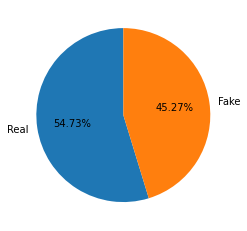

In [8]:
labels.loc[0,'Count'] = labels.loc[0,'Count'] - sum(data['Label']=='barely-true')

print(labels)

plt.pie(labels['Count'], labels = ['Real','Fake'], autopct = '%1.2f%%', startangle = 90)
plt.show()

This pie chart looks a lot more balanced! For building our models, we'll remove data points that are labeled as 'barely-true'.

# Data Cleaning and Preprocessing

The first thing we'll do to clean our data is remove duplicate headlines.

In [9]:
# Remove duplicate headlines

data_2 = data.drop_duplicates(subset=['News_Headline'])

Now we'll remove the data points that are labeled as 'full-flop', 'half-flip', 'no-flip', or 'barely-true'.

In [10]:
# Remove rows with unused labels

unused_labels = ['full-flop','half-flip','no-flip','barely-true']

data_3 = data_2[~data_2['Label'].isin(unused_labels)]

Let's add our binary label of '0' for real or '1' for fake.

In [11]:
# Add binary label

real = ['TRUE','mostly-true','half-true']
bin_label = []
for label in data_3['Label']:
    if label in real:
        bin_label.append(0)
    else:
        bin_label.append(1)
data_3['Bin_Label'] = bin_label

Our 'News_Headline' text will need some cleaning. We'll remove hex characters and stopwords. Stop words are basic, common words that are considered as uninformative.

In [12]:
# Remove hex characters

clean = []
for text in data_3['News_Headline']:
    clean.append(re.sub(r'[^\x00-\x7f]',r'', text))
data_3['Clean_Text'] = clean

In [13]:
# Remove stopwords

stop_words = stopwords.words('english')
data_3['Final_Text'] = data_3['Clean_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

Let's take a quick look at our data to make sure our feature 'Final_Text' and labels 'Bin_Label' looks good.

In [14]:
data_3

,News_Headline,Link_Of_News,Source,Stated_On,Date,Label,Bin_Label,Clean_Text,Final_Text
0,Says Osama bin Laden endorsed Joe Biden,https://www.politifact.com/factchecks/2020/jun...,Donald Trump Jr.,"June 18, 2020","June 19, 2020",FALSE,1,Says Osama bin Laden endorsed Joe Biden,Says Osama bin Laden endorsed Joe Biden
1,CNN aired a video of a toddler running away fr...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 18, 2020","June 19, 2020",pants-fire,1,CNN aired a video of a toddler running away fr...,CNN aired video toddler running away another t...
2,Says Tim Tebow kneeled in protest of abortion...,https://www.politifact.com/factchecks/2020/jun...,Facebook posts,"June 12, 2020","June 19, 2020",FALSE,1,Says Tim Tebow kneeled in protest of abortion ...,Says Tim Tebow kneeled protest abortion Nation...
4,"""Our health department, our city and our count...",https://www.politifact.com/factchecks/2020/jun...,Jeanette Kowalik,"June 14, 2020","June 18, 2020",TRUE,0,"""Our health department, our city and our count...","""Our health department, city county declared r..."
5,Says before he planned a rally on June 19 nob...,https://www.politifact.com/factchecks/2020/jun...,Donald Trump,"June 17, 2020","June 18, 2020",pants-fire,1,Says before he planned a rally on June 19 nobo...,Says planned rally June 19 nobody ever heard J...
...,...,...,...,...,...,...,...,...,...
9953,"Proposed cuts in the House farm bill mean ""2 m...",https://www.politifact.com/factchecks/2013/jun...,Barbara Lee,"June 17, 2013","June 21, 2013",mostly-true,0,"Proposed cuts in the House farm bill mean ""2 m...","Proposed cuts House farm bill mean ""2 million ..."
9954,"The state GOP ticket ""says their top priority ...",https://www.politifact.com/factchecks/2013/jun...,Terry McAuliffe,"June 12, 2013","June 21, 2013",FALSE,1,"The state GOP ticket ""says their top priority ...","The state GOP ticket ""says top priority career..."
9956,"The Foreign Intelligence Surveillance Court ""i...",https://www.politifact.com/factchecks/2013/jun...,Barack Obama,"June 17, 2013","June 21, 2013",pants-fire,1,"The Foreign Intelligence Surveillance Court ""i...","The Foreign Intelligence Surveillance Court ""i..."
9957,"""In the past four years, (the U.S. Senate) has...",https://www.politifact.com/factchecks/2013/jun...,Jack Kingston,"May 2, 2013 i","June 21, 2013",mostly-true,0,"""In the past four years, (the U.S. Senate) has...","""In past four years, (the U.S. Senate) passed ..."


Everything looks good! Now we will use tokenization to convert the text into a sequence of integers where each integer represents the index of a word in a dictionary. The sequences will be padded to a max length of 100.

In [15]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data_3['Final_Text'])
data_seq = tokenizer.texts_to_sequences(data_3['Final_Text'])
data_pad = pad_sequences(data_seq, maxlen = 100)

The last thing we need to do is split our data for training and testing. 20% of the data will be randomly selected for our test set and the remaining 80% will be our train set. The x data will also need to be reshaped to 3D.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data_pad, data_3['Bin_Label'], test_size=0.2, random_state=42)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Model Building and Training

Our first model will be a simple LSTM (Long Short Term Memory) model. This trains the model on the x data inputs at different LSTM layers. Each LSTM layer contains hidden states that are responsible for short term memory and cell states that are responsible for long term memory. Our model will use a total of 4 LSTM layers. The output layer uses sigmoid activation. We'll train our model over 30 iterations.

In [17]:
# LSTM Model

lstm_model = Sequential()

# Fist Layer
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))

# Second Layer
lstm_model.add(LSTM(units=50, return_sequences=True))

# Third Layer
lstm_model.add(LSTM(units=50, return_sequences=True))

# Fourth Layer
lstm_model.add(LSTM(units=50))

# Output Layer
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

2022-11-27 17:47:48.200178: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
# LSTM Model Summary

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [19]:
# LSTM Model Training

lstm_model_training = lstm_model.fit(x_train, y_train, epochs=30, validation_data=(x_test,y_test))

2022-11-27 17:47:55.343888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
203/203 [==============================] - 88s 386ms/step - loss: 0.6764 - accuracy: 0.5808 - auc: 0.5936 - val_loss: 0.6704 - val_accuracy: 0.6007 - val_auc: 0.6269
Epoch 2/30
203/203 [==============================] - 76s 376ms/step - loss: 0.6674 - accuracy: 0.5930 - auc: 0.6179 - val_loss: 0.6677 - val_accuracy: 0.5977 - val_auc: 0.6263
Epoch 3/30
203/203 [==============================] - 75s 371ms/step - loss: 0.6655 - accuracy: 0.6061 - auc: 0.6223 - val_loss: 0.6765 - val_accuracy: 0.5718 - val_auc: 0.6259
Epoch 4/30
203/203 [==============================] - 77s 381ms/step - loss: 0.6639 - accuracy: 0.6071 - auc: 0.6270 - val_loss: 0.6700 - val_accuracy: 0.5915 - val_auc: 0.6226
Epoch 5/30
203/203 [==============================] - 78s 383ms/step - loss: 0.6622 - accuracy: 0.6093 - auc: 0.6310 - val_loss: 0.6661 - val_accuracy: 0.5921 - val_auc: 0.6255
Epoch 6/30
203/203 [==============================] - 75s 370ms/step - loss: 0.6600 - accuracy: 0.6070 - auc: 0.634

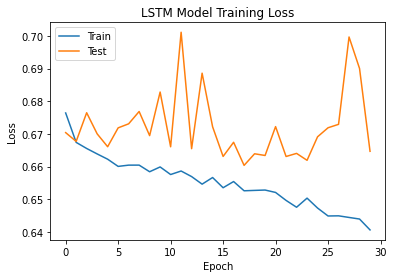

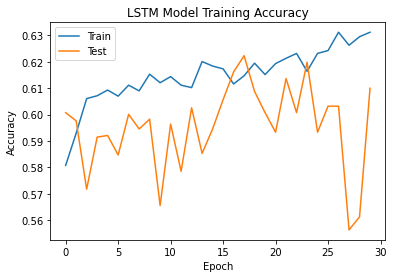

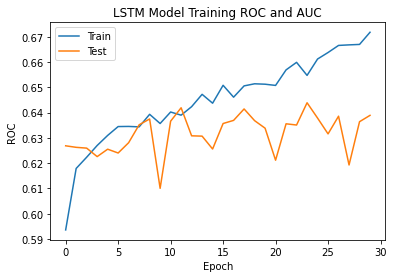

In [20]:
# LSTM Model Plots

plt.plot(lstm_model_training.history['loss'])
plt.plot(lstm_model_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Model Training Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(lstm_model_training.history['accuracy'])
plt.plot(lstm_model_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model Training Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(lstm_model_training.history['auc'])
plt.plot(lstm_model_training.history['val_auc'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('LSTM Model Training ROC and AUC')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

Our second model will be a GRU (Gated Recurrent Unit) model. GRU is very similar to LSTM but it is more simple. GRU layers do not have a cell state but it can still handle short-term and long-term memory. This model will have the same structure as our LSTM model with 30 iterations as well so that we can easily compare the two.

In [21]:
# GRU Model

gru_model = Sequential()

# Fist Layer
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))

# Second Layer
gru_model.add(GRU(units=50, return_sequences=True))

# Third Layer
gru_model.add(GRU(units=50, return_sequences=True))

# Fourth Layer
gru_model.add(GRU(units=50))

# Output Layer
gru_model.add(Dense(units=1, activation='sigmoid'))

gru_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

In [22]:
# GRU Model Summary

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 50)           7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 53,901
Trainable params: 53,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
# GRU Model Training

gru_model_training = gru_model.fit(x_train, y_train, epochs=30, validation_data=(x_test,y_test))

Epoch 1/30
203/203 [==============================] - 103s 455ms/step - loss: 0.6779 - accuracy: 0.5745 - auc_1: 0.5851 - val_loss: 0.6684 - val_accuracy: 0.5946 - val_auc_1: 0.6232
Epoch 2/30
203/203 [==============================] - 92s 451ms/step - loss: 0.6688 - accuracy: 0.6001 - auc_1: 0.6122 - val_loss: 0.6665 - val_accuracy: 0.6007 - val_auc_1: 0.6263
Epoch 3/30
203/203 [==============================] - 93s 456ms/step - loss: 0.6670 - accuracy: 0.5985 - auc_1: 0.6175 - val_loss: 0.6711 - val_accuracy: 0.5853 - val_auc_1: 0.6258
Epoch 4/30
203/203 [==============================] - 90s 444ms/step - loss: 0.6667 - accuracy: 0.6024 - auc_1: 0.6172 - val_loss: 0.6654 - val_accuracy: 0.5940 - val_auc_1: 0.6296
Epoch 5/30
203/203 [==============================] - 90s 443ms/step - loss: 0.6637 - accuracy: 0.6033 - auc_1: 0.6260 - val_loss: 0.6652 - val_accuracy: 0.6001 - val_auc_1: 0.6271
Epoch 6/30
203/203 [==============================] - 91s 447ms/step - loss: 0.6630 - accuracy

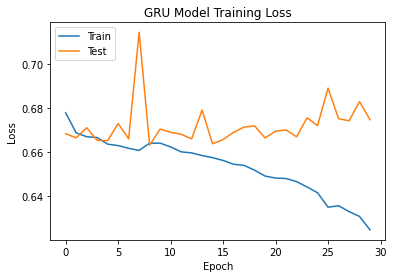

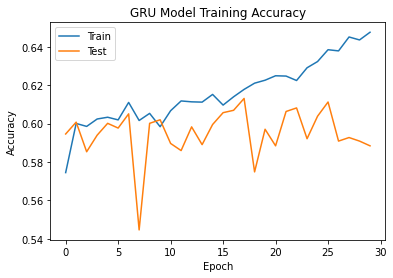

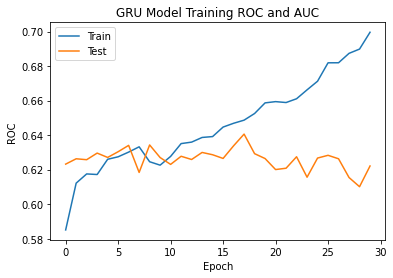

In [24]:
# GRU Model Plots

plt.plot(gru_model_training.history['loss'])
plt.plot(gru_model_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Model Training Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(gru_model_training.history['accuracy'])
plt.plot(gru_model_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GRU Model Training Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(gru_model_training.history['auc_1'])
plt.plot(gru_model_training.history['val_auc_1'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('GRU Model Training ROC and AUC')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

Even though GRU models are more simple than LSTM models, our LSTM model actually performed slightly better than our GRU model according to our plots for the two models. For our third model, we will build a little more advanced LSTM model. We will add a fifth layer, and each layer will include tanh activation as well as a Dropout rate of 0.1.

In [25]:
# Advanced LSTM Model

adv_lstm_model = Sequential()

# Fist Layer
adv_lstm_model.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],1)))
adv_lstm_model.add(Dropout(0.1))

# Second Layer
adv_lstm_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
adv_lstm_model.add(Dropout(0.1))

# Third Layer
adv_lstm_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
adv_lstm_model.add(Dropout(0.1))

# Fourth Layer
adv_lstm_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
adv_lstm_model.add(Dropout(0.1))

# Fifth Layer
adv_lstm_model.add(LSTM(units=50))
adv_lstm_model.add(Dropout(0.1))

# Output Layer
adv_lstm_model.add(Dense(units=1, activation='sigmoid'))

adv_lstm_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])

In [26]:
# Advanced LSTM Model Summary

adv_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)          

In [27]:
# Advanced LSTM Model Training

adv_lstm_model_training = adv_lstm_model.fit(x_train, y_train, epochs=30, validation_data=(x_test,y_test))

Epoch 1/30
203/203 [==============================] - 116s 514ms/step - loss: 0.6803 - accuracy: 0.5726 - auc_2: 0.5744 - val_loss: 0.6720 - val_accuracy: 0.5995 - val_auc_2: 0.6242
Epoch 2/30
203/203 [==============================] - 98s 482ms/step - loss: 0.6684 - accuracy: 0.5994 - auc_2: 0.6168 - val_loss: 0.6705 - val_accuracy: 0.5940 - val_auc_2: 0.6211
Epoch 3/30
203/203 [==============================] - 96s 472ms/step - loss: 0.6650 - accuracy: 0.5982 - auc_2: 0.6243 - val_loss: 0.6691 - val_accuracy: 0.5970 - val_auc_2: 0.6234
Epoch 4/30
203/203 [==============================] - 98s 481ms/step - loss: 0.6646 - accuracy: 0.6021 - auc_2: 0.6252 - val_loss: 0.6713 - val_accuracy: 0.5878 - val_auc_2: 0.6198
Epoch 5/30
203/203 [==============================] - 96s 472ms/step - loss: 0.6636 - accuracy: 0.6064 - auc_2: 0.6259 - val_loss: 0.6651 - val_accuracy: 0.6007 - val_auc_2: 0.6298
Epoch 6/30
203/203 [==============================] - 97s 479ms/step - loss: 0.6624 - accuracy

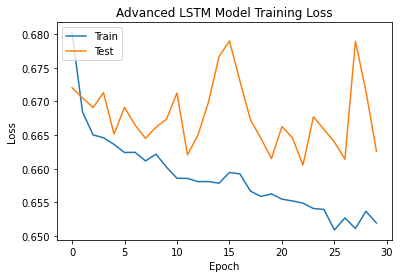

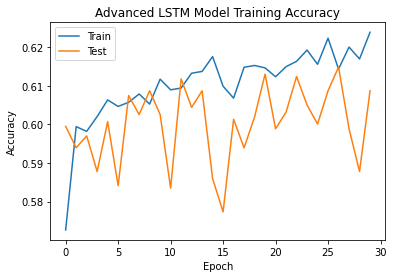

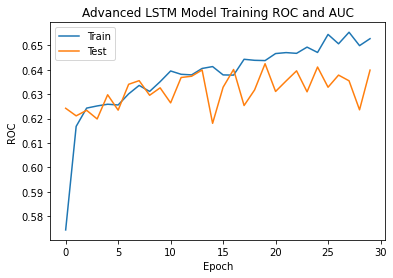

In [28]:
# Advanced LSTM Model Plots

plt.plot(adv_lstm_model_training.history['loss'])
plt.plot(adv_lstm_model_training.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Advanced LSTM Model Training Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(adv_lstm_model_training.history['accuracy'])
plt.plot(adv_lstm_model_training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Advanced LSTM Model Training Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

plt.plot(adv_lstm_model_training.history['auc_2'])
plt.plot(adv_lstm_model_training.history['val_auc_2'])
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('Advanced LSTM Model Training ROC and AUC')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

# Results

In [29]:
m1 = [lstm_model_training.history['loss'][29],lstm_model_training.history['val_loss'][29],lstm_model_training.history['accuracy'][29],lstm_model_training.history['val_accuracy'][29],lstm_model_training.history['auc'][29],lstm_model_training.history['val_auc'][29]]
m1 = [round(x,2) for x in m1]
m2 = [gru_model_training.history['loss'][29],gru_model_training.history['val_loss'][29],gru_model_training.history['accuracy'][29],gru_model_training.history['val_accuracy'][29],gru_model_training.history['auc_1'][29],gru_model_training.history['val_auc_1'][29]]
m2 = [round(x,2) for x in m2]
m3 = [adv_lstm_model_training.history['loss'][29],adv_lstm_model_training.history['val_loss'][29],adv_lstm_model_training.history['accuracy'][29],adv_lstm_model_training.history['val_accuracy'][29],adv_lstm_model_training.history['auc_2'][29],adv_lstm_model_training.history['val_auc_2'][29]]
m3 = [round(x,2) for x in m3]
col_names = ['Train Loss','Test Loss','Train Accuracy','Test Accuracy','Train AUC','Test AUC']
row_names = ['LSTM','GRU','Adv LSTM']
res = pd.DataFrame([m1,m2,m3],row_names,col_names)
res

,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Train AUC,Test AUC
LSTM,0.64,0.66,0.63,0.61,0.67,0.64
GRU,0.62,0.67,0.65,0.59,0.70,0.62
Adv LSTM,0.65,0.66,0.62,0.61,0.65,0.64


The table above shows the three metrics 'Loss', 'Accuracy', and 'AUC' for each of the three models on the training and testing data after 30 iterations.

The Loss on the test data was about the same for all three models (approx 0.66) after 30 iterations. For Accuracy was the same for the two LSTM models (0.61), but both were slightly better than the GRU model (0.59). The same can be said for the AUC metric, 0.64 for the two LSTM models and 0.62 for the GRU model. Looking at all the plots for the metrics of the three models, it appears they all converged so more training iterations wouldn't seem to improve any of the models.

# Conclusion

After building and training three models, we can't conclude that any of them are better or worse than the other two as they all have very similar metric values. If we had to select one model to present to a company for detecting fake news, we would present our first simple LSTM model. This is because the LSTM models were slightly better than the GRU model, and the first LSTM model is more simple than the second more advanced model.

Our simple LSTM model produced a Loss of 0.66, an Accuracy of 0.61, and an AUC of 0.64 on the testing dataset. These metrics are decent but aren't all that great. This proves how hard it is to identify fake news. If it's hard for machine learning, it's even harder for humans to be able to determine what's real and what's not in the news and on social media sites. It really is easy to spread fake news and have people believe it.

In the future, we would definitely need to attempt to improve our model. There are a number of ways to alter both the LSTM and GRU models to see if any combination of layers and hyperparamters in the model can produce better results.

# References

https://www.kaggle.com/datasets/techykajal/fakereal-news?datasetId=733642